# Machine learning to analyze Enron Dataset
**Udacity Nanodegree P5 project**

*Author: Jie Hu,  jie.hu.ds@gmail.com*

------------

## 0. Abstract

This is a project in which I use skills learned from Udacity course, including data wrangling, exploratory data analysis and machine learning, to do research on [Enron Fraud Email dataset](https://www.cs.cmu.edu/~./enron/).

The goal of this research is to find out most significant features to predict whether a person in the dataset is committed to fraud. The structure of this article is:
- Data Wrangling, in which I modify NA values and remove outliers
- Feature Selecting, in which I create some features I think important to predict fraud
- Training and tuning machine learning, in which I use sklearn to train 4 different models and compare their performance matrices, including precision, recall and f1 score
- Final part, in which I select Naive Bayes as my best model
- Conclusion

## 1. Data Wrangling

Firstly, load the dataset:

In [2]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import StratifiedKFold

In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

The dataset has 146 observations (people) including 18 person of interest (poi). And there're totally 21 features. Beside 'email_address' (string) and 'poi' (bool), all features are numeric.

It's a highly skewed data because the target 2 labels for classification are greatly unbalanced: poi people take up only 12.3% dataset.

Beside, the data has a lot of NA values of each features:

In [4]:
persons = data_dict.keys()
keys = data_dict[data_dict.keys()[1]].keys()

In [5]:
# Check 'NaN' value of each feature in dict_data
NA_count = {}

for person in persons:
    for key in keys:
        if data_dict[person][key] == 'NaN':
            if not NA_count.has_key(key):
                NA_count[key] = 1
            else:
                NA_count[key] += 1

In [6]:
NA_count

{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}

So the first thing needed to be done is to replace these 'NaN' values.
Because for financial data, 'NaN' most likely mean he/she had no such income, so it's 0 
And for email data, it can also be 0 if there's no such count, so I replace all numeric 'NaN' values by 0. Now most NA values are replaced, we only have people without email address, which is reasonable and can be ignored.

In [7]:
# Before doing any feature selection and creation work, I remove the 'NaN'
# Because for financial data, 'NaN' most likely mean he/she had no such income, so it's 0
# And for email data, it can also be 0 if there's no such count
for person in persons:
    for key in keys:
        if data_dict[person][key] == 'NaN' and key != 'email_address':
            data_dict[person][key] = 0

In [8]:
# Now NAs have been removed (Only email has NaN but it doesn't matter):
NA_count = {}

for person in persons:
    for key in keys:
        if data_dict[person][key] == 'NaN':
            if not NA_count.has_key(key):
                NA_count[key] = 1
            else:
                NA_count[key] += 1
NA_count

{'email_address': 35}

The pros of such NA value replacement are:

- use reasonable logic to better fit the data
- good for training models

But there's con:
- some data might be real missing values (real value can be non-0!), for example, typo, unintended missing etc. Set them to 0 might have risk to bias the result

To go deeper, I have to assume the NA data be all values such person doesn't have.

Beside, outliers are harmful for analysis. After all, they can significantly biased any model. For example, if I use Decision Tree, outliers can setup new rules but actually it's sometimes meaningless. However, some outliers, if they are not a wiered point, and it belongs to the true data, I will keep them.

Here let's check if there's strange outliers. Let's pick up some feature combination and use scatter plot to check:


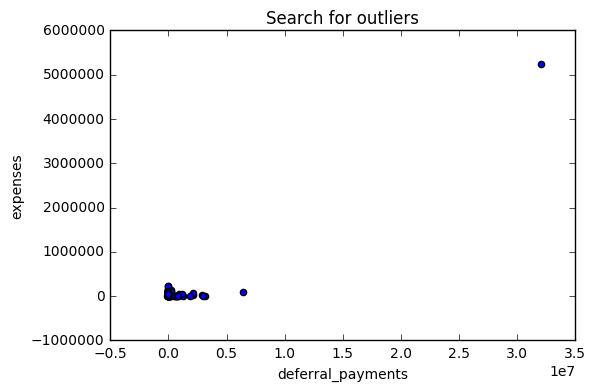

In [10]:
### Task 3: Remove outliers

# Because I'm not using simple linear model for next steps 
# so if the outliers are from data points, even it's outlier, I will keep it
# otherwise I will remove it

# Firstly, let's do some visualization by using 2-dimensional data

features_list = ['deferral_payments','expenses']

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset
data = featureFormat(my_dataset, features_list, sort_keys = True)

import matplotlib.pyplot as plt

for point in data:
    deferral_payments = point[0]
    expenses = point[1]
    plt.scatter( deferral_payments, expenses )

plt.xlabel("deferral_payments")
plt.ylabel("expenses")
plt.title("Search for outliers")
plt.show()

We can see there's one point significantly far from center, let's see what it is:

In [11]:
for person in persons:
    if data_dict[person]['deferral_payments'] > 20000000:
        print person

TOTAL


It's unlikely for anyone to have name 'TOTAL', a more reasonable explaination is that this is summary of sum of feature values. So I remove this 'TOTAL' otherwise it might bias my models.

In [12]:
data_dict.pop('TOTAL')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 0,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 0,
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 0,
 'to_messages': 0,
 'total_payments': 309886585,
 'total_stock_value': 434509511}

Then let's zoom in and see if there's other unreasonable outliers

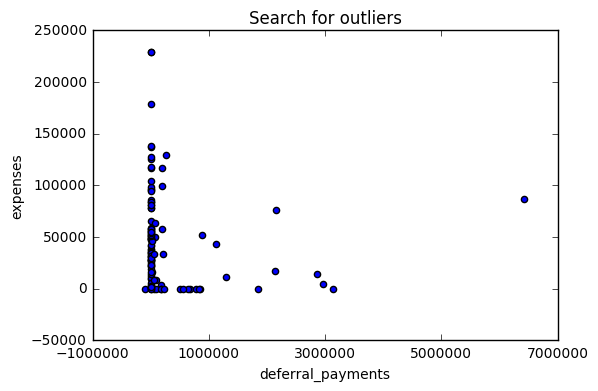

In [13]:
features_list = ['deferral_payments','expenses']

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset
data = featureFormat(my_dataset, features_list, sort_keys = True)

for point in data:
    deferral_payments = point[0]
    expenses = point[1]
    plt.scatter( deferral_payments, expenses )

plt.xlabel("deferral_payments")
plt.ylabel("expenses")
plt.xticks(range(-1000000, 8000000, 2000000))
plt.title("Search for outliers")
plt.show()

At least 4 outliers are detected visually. Let's look at these outliers

In [14]:
persons.remove('TOTAL')
for person in persons:
    if data_dict[person]['deferral_payments'] > 5000000 or data_dict[person]['expenses'] > 150000:
        print person

SHANKMAN JEFFREY A
URQUHART JOHN A
MCCLELLAN GEORGE
FREVERT MARK A


These are all names of people, and they are not by mistakes. Since they include much information I need, to keep these outliers will be a good choice.

After check other combinations, I decide to keep all remaining data because the outliers will have a lot of information which could be significant indicator of poi.

## 2. Select features, choose algorithms and tuning for best performance


#### 2.1 Before Start
Feature selecting depends a lot on which algorithm to be used, so to explore alroghtm and feature selection independently might miss the best match to the dataset. Therefore, instead of seperate the feature selection part and choose algorithm, I put these 2 steps together. In this section, I will:

- Firstly, choose algorithm, it will be Naive Bayes, and Decision Tree (Implementing more algorithms will be similar)
- Pipeline selecting features, PCA, fit the model and tuning for algorithm
- Get the best score, precision and recall rate such algorithm can achieve, and the number of features it uses
- After finish all 4 algorithms, I put the results together and make comparison to determine which algorithms

To begin with I create 3 features I think could possibly be indicators for poi:

- 'fixed_income': earned from how they contribute to work, salary + bonus
- 'stock_income': all income from stock, restricted_stock_deferred + exercised_stock_options + restricted_stock
- 'email_proportion_with_poi': 
- proportion of their emails frequency with poi over all email

Now I add these features to feature list ('poi' will be put at beginning and 'email_addresses' will be removed because it's meaningless to achieve my target):

In [15]:
# Then I create features:
# created_feature_list:

### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

for person in persons:
    salary = float(data_dict[person]['salary'])
    bonus = float(data_dict[person]['bonus'])
    restricted_stock_deferred = float(data_dict[person]['restricted_stock_deferred'])
    exercised_stock_options = float(data_dict[person]['exercised_stock_options'])
    restricted_stock = float(data_dict[person]['restricted_stock'])
    
    from_this_person_to_poi = float(data_dict[person]['from_this_person_to_poi'])
    shared_receipt_with_poi = float(data_dict[person]['shared_receipt_with_poi'])
    from_poi_to_this_person = float(data_dict[person]['from_poi_to_this_person'])
    to_messages = float(data_dict[person]['to_messages'])
    from_messages = float(data_dict[person]['from_messages'])
    
    data_dict[person]['fixed_income'] = salary + bonus 
    data_dict[person]['stock_income'] = (restricted_stock_deferred + \
                                         exercised_stock_options + \
                                         restricted_stock)
    data_dict[person]['email_proportion_with_poi'] = (from_this_person_to_poi + \
                                                         shared_receipt_with_poi + \
                                                         from_poi_to_this_person)/ \
                                                        (to_messages + from_messages + 1)


features_list = data_dict[persons[0]].keys() + ['fixed_income', 'stock_income', 'email_proportion_with_poi']
features_list.insert(0, features_list.pop(features_list.index('poi')))
features_list.pop(features_list.index('email_address'))
len(features_list)

26

Now I have totally 25 features and 1 label 'poi', I use them to restructure my dataset:

In [16]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

Because the algorithms I will use (Naive Bayes and Bayes) will not be influenced by scale of each feature, scaling the features is not necessary. (If you want to implement algorithms like SVM, Kmeans, scale the features is a must because these algorithms matters a lot with distance calculation).

#### 2.2 Tuning Naive Bayes

Considering the imbalanced structure of this dataset (there're much more non-poi than poi people), I will use stratified sample. As Gaussian Naive Bayes do not have any parameters, the pipeline I will use is simple:

In [24]:
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test =  train_test_split(
    features,
    labels,
    test_size=0.2, 
    random_state=42
    )

Because the data is very imbalanced, so here I use stratefied sample. And to make sure there're approximately same ratio of poi vs. non-poi, here I check:

In [25]:
sum(labels_test)/len(labels_test)

0.068965517241379309

In [28]:
sum(labels)/len(labels)

0.125

It's a good ratio. Now let's continue to train:

In [29]:
skb = SelectKBest(f_classif)
pca = PCA()
clf_GNB = GaussianNB()

pipeline= Pipeline(steps=[("SKB", skb), ("PCA", pca), ("NaiveBayes", clf_GNB)])

pca_params = {"PCA__n_components":[2, 4, 6, 8], 
              "PCA__whiten": [True],
              "SKB__k":[8,10,14,16,18]}

cv = StratifiedShuffleSplit(labels_train, 
                            n_iter = 100, 
                            random_state = 42)

clf = GridSearchCV(
    pipeline,
    pca_params,
    # n_jobs = -1,
    verbose = 0,
    scoring = 'f1_weighted',
    cv = cv
)

In [30]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
precision = precision_score(labels_test, prediction)
recall = recall_score(labels_test, prediction)
accuracy = accuracy_score(labels_test, prediction)
f1Score = f1_score(labels_test, prediction)
    
    
print '------------------------'
print 'Accuracy: %s' % "{:,.3f}".format(round(accuracy, 3)) 
print 'Precision: %s' % "{:,.3f}".format(round(precision, 3))
print 'Recall   : %s' % "{:,.3f}".format(round(recall, 3))
print 'F1 score:  %s' % "{:,.3f}".format(round(f1Score, 3))
    

------------------------
Accuracy: 0.931
Precision: 0.500
Recall   : 0.500
F1 score:  0.500


In [31]:
clf.best_params_

{'PCA__n_components': 6, 'PCA__whiten': True, 'SKB__k': 18}

For Naive Bayes:

- I get the best model with: accuracy(0.862), precision(0.5), and recall(0.25)
- Number of principle components is 8
- The best classifier has: K = 16 for kBest feature selection, and the features are:

In [31]:
features_selected_bool = clf.best_estimator_.named_steps['SKB'].get_support()
features_selected_list = [x for x, y in zip(features_list[1:], features_selected_bool) if y]
features_selected_list

['expenses',
 'fixed_income',
 'deferred_income',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'loan_advances',
 'email_proportion_with_poi',
 'bonus',
 'total_stock_value',
 'from_poi_to_this_person',
 'stock_income',
 'restricted_stock',
 'salary',
 'total_payments',
 'exercised_stock_options',
 'fixed_income',
 'stock_income',
 'email_proportion_with_poi']

#### 2.3 Tuning Decision Tree

The process is similar, here I set up the pipeline and use exactly the same training and test set:

In [32]:
skb = SelectKBest(f_classif)
pca = PCA()
clf_DT = DecisionTreeClassifier()

pipeline= Pipeline(steps=[("SKB", skb), ("PCA", pca), ("DecisionTree", clf_DT)])

params = {'PCA__n_components':[2, 4, 6], 
          'PCA__whiten': [True],
          'SKB__k':[8,14,18]}

cv = StratifiedShuffleSplit(labels_train, 
                            n_iter = 25, 
                            random_state = 21)

clf = GridSearchCV(
    pipeline,
    params,
    # n_jobs = -1,
    verbose = 0,
    scoring = 'f1_weighted',
    cv = cv
)

In [33]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
precision = precision_score(labels_test, prediction)
recall = recall_score(labels_test, prediction)
accuracy = accuracy_score(labels_test, prediction)
    
    
print '------------------------'
print 'Accuracy: %s' % "{:,.3f}".format(round(accuracy, 3)) 
print 'Precision: %s' % "{:,.3f}".format(round(precision, 3))
print 'Recall   : %s' % "{:,.3f}".format(round(recall, 3))

avg_F1 = 2 * (precision * recall) / (precision + recall)
print 'F1 score:  %s' % "{:,.3f}".format(round(avg_F1, 3))
    

------------------------
Accuracy: 0.897
Precision: 0.400
Recall   : 1.000
F1 score:  0.571


In [ ]:
zip(labels_test, prediction)

In [ ]:
clf2 = DecisionTreeClassifier()
clf2.fit(features_train, labels_train)
pred = clf2.predict(features_test)
precision_score(pred, labels_test)

In [ ]:
clf.best_params_

The best features for decision tree model is:



For Naive Bayes:

- I get the best model with: accuracy(0.862), precision(0.5), and recall(0.25)
- Number of principle components is 8
- The best classifier has: K = 16 for kBest feature selection, and the features are:

In [ ]:
features_selected_bool = clf.best_estimator_.named_steps['SKB'].get_support()
features_selected_list = [x for x, y in zip(features_list[1:], features_selected_bool) if y]
features_selected_list

## 4. Final Discuss with Naive Bayes

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)


clf = GaussianNB()
    
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

By Naive Beyes, the most significant indicators are:

I then run this model with test.py and get the result:

Accuracy: 0.85679	
Precision: 0.49840	
Recall: 0.38900	
F1: 0.43696	
F2: 0.40686
Total predictions: 14000	
True positives:  778	
False positives:  783	
False negatives: 1222	
True negatives: 11217

This is pretty close to the result I get with 146-length dataset.

The features I created also act as essential part of this model. Let's compare the result with / without the features I created.

In [ ]:
features_list = ['poi','deferred_income',
                 'total_stock_value'] 
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

clf = GaussianNB()
parameters = {}
grid_search = GridSearchCV(clf, parameters)
print '\nGaussian Naive Bayes:'
classifer_tester(clf, features, labels, parameters)

Score Type|With New Features|Without New Features
------------|------------|------------
Accuracy|0.86|0.87
Precision|0.43|0.50
Recall|0.37|0.34
F1 score|0.40|0.41

Even without the features I created, the model will have more accuracy, precision and f1 score, I prefer using with created features to keep recall rate higher. Since higher recall rate means lower risk to label non-poi if he's truely poi. We can set up inquiries beside this analysis to make further judgement, but missing a poi is harmful. So even sacrifice precision, I would keep the created new features to increase recall rate. 

## 5. Conclusion

In this report I firstly summarize the dataset, remove outliers and replace NaN values. Next, I create 3 features and figure out which features to be selected by sklearn KBest method. Then I rescale the dataset and use these features to train different model, and finally find Naive Bayes as my best model.

This is a quantative analysis and can only be a reference for commitment. The real procedure of convict guilty will be more complicated.

In future, to improve the accuracy of the model, I think there're some ways we can try:
- Given more detailed dataset, more features might have risk of overfitting, but more data can possibly provide more informaiton we need
- Mining more information from emails, for example, how they communicate with Enron's partners, how they poi communicate with each other